# World happiness index: finding regions

## Importing modules

Import the required modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Problem setting

Let's see whether it can be predicted from the numerical attributes whether a country is Western European or not. This is a classic binary classification problem.

## Importing training data

In [2]:
data_2015 = pd.read_csv('Data/world_happiness_2015.csv')

In [4]:
data_2015.describe()
data_2015

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176
...,...,...,...,...,...,...,...,...,...,...,...,...
153,Rwanda,Sub-Saharan Africa,154,3.465,0.03464,0.22208,0.77370,0.42864,0.59201,0.55191,0.22628,0.67042
154,Benin,Sub-Saharan Africa,155,3.340,0.03656,0.28665,0.35386,0.31910,0.48450,0.08010,0.18260,1.63328
155,Syria,Middle East and Northern Africa,156,3.006,0.05015,0.66320,0.47489,0.72193,0.15684,0.18906,0.47179,0.32858
156,Burundi,Sub-Saharan Africa,157,2.905,0.08658,0.01530,0.41587,0.22396,0.11850,0.10062,0.19727,1.83302


## Analysis

Let's check how many countries each region has.  If there are too few, it makes no sense to include those in the training set.

In [9]:
region_count = pd.crosstab(index=data_2015['Region'], columns='count')
region_count

col_0,count
Region,
Australia and New Zealand,2
Central and Eastern Europe,29
Eastern Asia,6
Latin America and Caribbean,22
Middle East and Northern Africa,20
North America,2
Southeastern Asia,9
Southern Asia,7
Sub-Saharan Africa,40


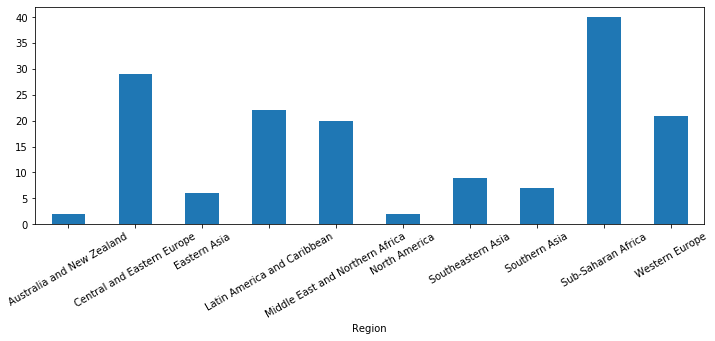

In [7]:
region_count.plot(kind='bar', legend=False, rot=30, figsize=(12, 4));

## Preprocess data

Define a class to extract data from a pandas DataFrame.

In [10]:
class FeatureSelector(BaseException, TransformerMixin):
    def __init__(self, feature_names):
        self._feature_names = feature_names
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        return X[self._feature_names].values

Define numerical atribute names.

In [11]:
num_attr_names = ['Economy (GDP per Capita)',
                  'Family', 'Health (Life Expectancy)', 'Freedom',
                  'Trust (Government Corruption)', 'Generosity',
                  'Dystopia Residual']

In [12]:
num_attrs_pipeline = Pipeline([
    ('select_num_attrs', FeatureSelector(num_attr_names)),
    ('scaler', MinMaxScaler()),
])

In [13]:
prepared_data = num_attrs_pipeline.fit_transform(data_2015)

Add a column to the data frame that has the value `True` if the country is in Western Europe, `False` otherwise.

In [14]:
data_2015['Western Europe'] = data_2015['Region'] == 'Western Europe'

## Training

Since the numerical attributes are reasonably described by a Gaussian distribution, we'll try to classify using a Gaussian Naive Bayes algorithm.

In [15]:
nb = GaussianNB()

In [16]:
nb.fit(prepared_data, data_2015['Western Europe'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [17]:
nb.score(prepared_data, data_2015['Western Europe'])

0.9367088607594937

Let's try cross validation to gauge performance.

In [18]:
cross_val_score(nb, prepared_data, data_2015['Western Europe'],
                scoring='accuracy', cv=15)

array([0.54545455, 1.        , 0.90909091, 0.90909091, 0.90909091,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9       , 1.        , 0.9       , 0.9       , 0.9       ])

Compute the confusion matrix.

In [19]:
confusion_matrix(data_2015['Western Europe'], nb.predict(prepared_data))

array([[130,   7],
       [  3,  18]], dtype=int64)

So 7 countries that are not in Western Europe are classified into that region (false positives), while 3 Western European countries are classified as situated elsewhere (false negatives).

In [20]:
for country, region, pred_region in zip(data_2015['Country'],
                                        data_2015['Western Europe'],
                                        nb.predict(prepared_data)):
    if region != pred_region:
        print('{0}: {1} -> {2}'.format(country, region, pred_region))

Canada: False -> True
New Zealand: False -> True
Australia: False -> True
Israel: False -> True
United States: False -> True
Taiwan: False -> True
Slovenia: False -> True
Cyprus: True -> False
Portugal: True -> False
Greece: True -> False


A number of countries seem to have become "honorary" Western Europeans, while only three have been "demoted".

## Testing

Read the 2016 testing data.

In [21]:
data_2016 = pd.read_csv('Data/world_happiness_2016.csv')

In [22]:
data_2016['Western Europe'] = data_2016['Region'] == 'Western Europe'

In [23]:
prepared_test_data = num_attrs_pipeline.transform(data_2016)

In [25]:
nb.score(prepared_test_data, data_2016['Western Europe'])

0.8662420382165605

In [26]:
for country, region, pred_region in zip(data_2016['Country'],
                                        data_2016['Western Europe'],
                                        nb.predict(prepared_test_data)):
    if region != pred_region:
        print('{0}: {1} -> {2}'.format(country, region, pred_region))

Denmark: True -> False
Norway: True -> False
Finland: True -> False
Canada: False -> True
Netherlands: True -> False
New Zealand: False -> True
Australia: False -> True
Austria: True -> False
Germany: True -> False
Belgium: True -> False
Ireland: True -> False
Luxembourg: True -> False
United Kingdom: True -> False
Malta: True -> False
France: True -> False
Italy: True -> False
Japan: False -> True
North Cyprus: True -> False
Cyprus: True -> False
Portugal: True -> False
Greece: True -> False


In [27]:
confusion_matrix(data_2016['Western Europe'], nb.predict(prepared_test_data))

array([[132,   4],
       [ 17,   4]], dtype=int64)

Oops, 17 Western European countries have left the region, this is clearly a rather bad classifier. Note that this is much less obvious when considering only the score.